In [2]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

simplefilter("ignore")  # ignore warnings to clean up output cells

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# Load Tunnel Traffic dataset
data_dir = Path("../input/ts-course-data")
tunnel = pd.read_csv(data_dir / "tunnel.csv", parse_dates=["Day"])
tunnel = tunnel.set_index("Day").to_period()

Text(0.5, 1.0, 'Tunnel Traffic - 365-Day Moving Average')

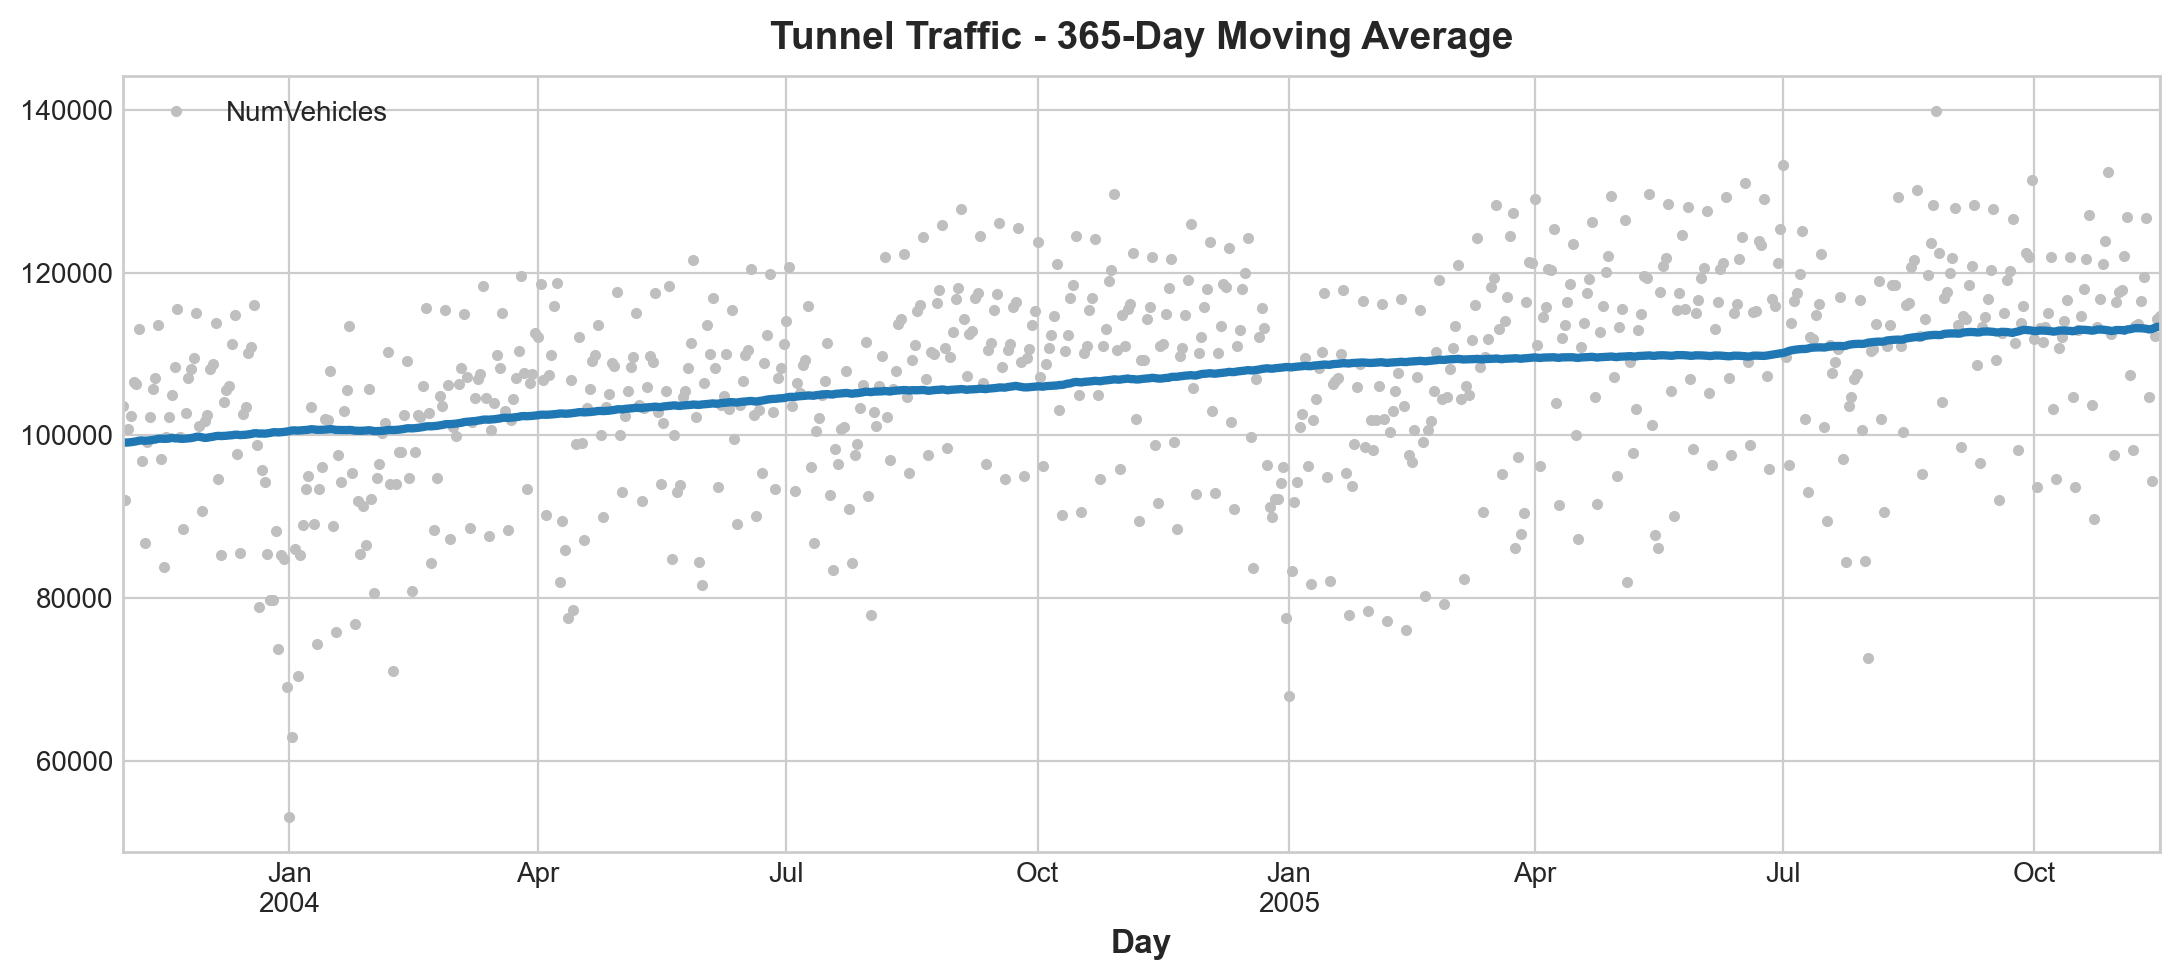

In [6]:
moving_average = tunnel.rolling(window=365, min_periods=183, center=True).mean()

ax = tunnel.plot(style='.',color='0.75')
ax = moving_average.plot(ax=ax,linewidth=3, legend=False)
ax.set_title("Tunnel Traffic - 365-Day Moving Average")

In [7]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=tunnel.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)

# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

,const,trend
Day,,
2003-11-01,1.0,1.0
2003-11-02,1.0,2.0
2003-11-03,1.0,3.0
2003-11-04,1.0,4.0
2003-11-05,1.0,5.0


In [8]:
help(DeterministicProcess)

Help on class DeterministicProcess in module statsmodels.tsa.deterministic:

class DeterministicProcess(builtins.object)
 |  DeterministicProcess(index: Union[Sequence[Hashable], pandas.core.indexes.base.Index], *, period: Union[float, int, NoneType] = None, constant: bool = False, order: int = 0, seasonal: bool = False, fourier: int = 0, additional_terms: Sequence[statsmodels.tsa.deterministic.DeterministicTerm] = (), drop: bool = False)
 |  
 |  Container class for deterministic terms.
 |  
 |  Directly supports constants, time trends, and either seasonal dummies or
 |  fourier terms for a single cycle. Additional deterministic terms beyond
 |  the set that can be directly initialized through the constructor can be
 |  added.
 |  
 |  Parameters
 |  ----------
 |  index : {Sequence[Hashable], pd.Index}
 |      The index of the process. Should usually be the "in-sample" index when
 |      used in forecasting applications.
 |  period : {float, int}, default None
 |      The period of t

In [9]:
help(dp.in_sample)

Help on method in_sample in module statsmodels.tsa.deterministic:

in_sample() -> pandas.core.frame.DataFrame method of statsmodels.tsa.deterministic.DeterministicProcess instance
    Produce deterministic trends for in-sample fitting.
    
    Parameters
    ----------
    index : index_like
        An index-like object. If not an index, it is converted to an
        index.
    
    Returns
    -------
    DataFrame
        A DataFrame containing the deterministic terms.



In [11]:
from sklearn.linear_model import LinearRegression

y = tunnel["NumVehicles"]  # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

In [12]:
X = dp.out_of_sample(steps=30)

y_fore = pd.Series(model.predict(X), index=X.index)

y_fore.head()

2005-11-17    114981.801146
2005-11-18    115004.298595
2005-11-19    115026.796045
2005-11-20    115049.293494
2005-11-21    115071.790944
Freq: D, dtype: float64

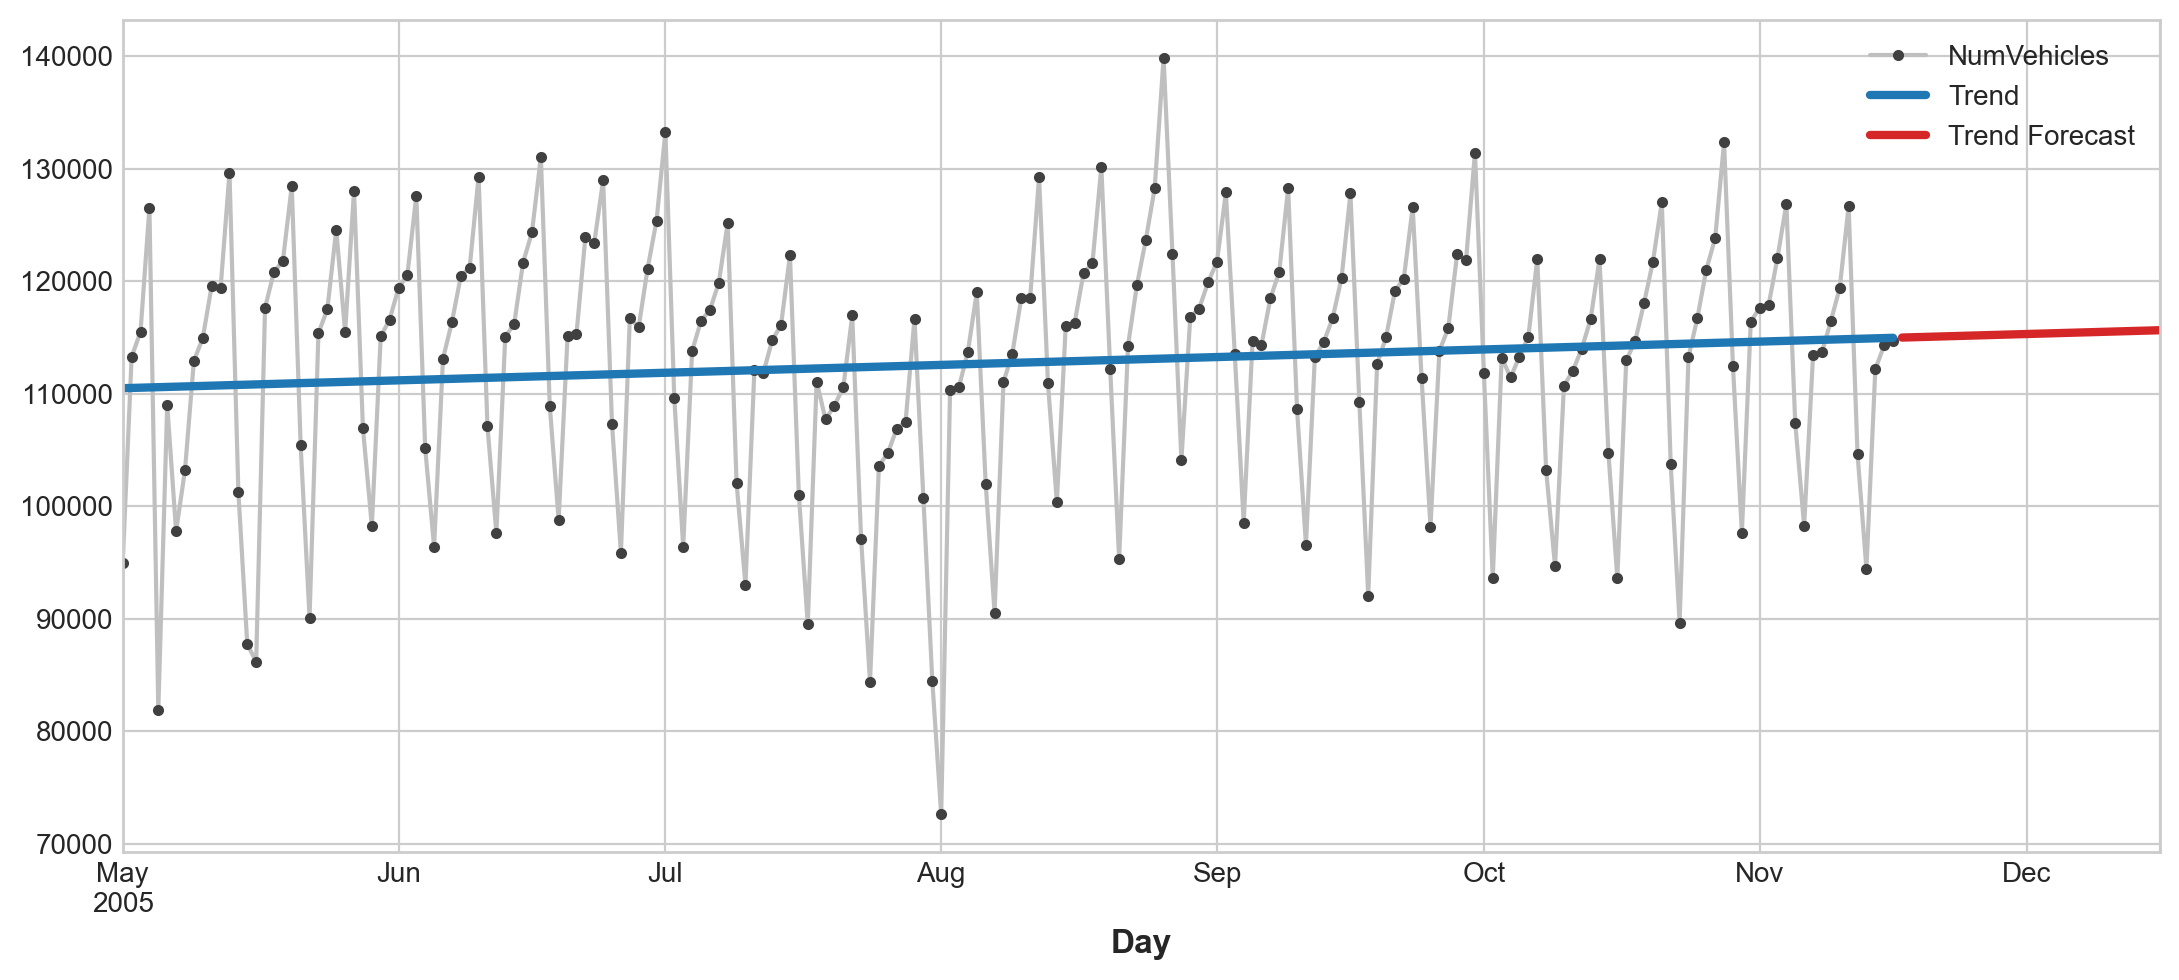

In [14]:
ax = tunnel["2005-05":].plot(**plot_params)
ax = y_pred["2005-05":].plot(ax=ax,linewidth=3,label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()
# ax = tunnel["2005-05":].plot(title="Tunnel Traffic - Linear Trend Forecast", **plot_params)
# ax = y_pred["2005-05":].plot(ax=ax, linewidth=3, label="Trend")
# ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
# _ = ax.legend()